In [59]:
import matplotlib as plt
import util
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

from six.moves import cPickle as pickle
from six.moves import xrange 

%matplotlib inline

IMAGE_SHAPE=[32,32,3]
NUM_CLASSES=10

In [60]:
def _parse(example_proto, augment):
  features = tf.parse_single_example(
        example_proto,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
  image = tf.decode_raw(features['image'], tf.uint8)
  #image = tf.cast(image, tf.float32)
  #image = scale_image(image)
  image = tf.reshape(image, IMAGE_SHAPE)
  
  #if augment:
  #    # Pad 4 pixels on each dimension of feature map, done in mini-batch
  #    image = tf.image.resize_image_with_crop_or_pad(image, 40, 40)
  #    image = tf.random_crop(image, IMAGE_SHAPE)
  #    image = tf.image.random_flip_left_right(image)

     
  label = features['label']
  label = tf.one_hot(label, NUM_CLASSES)
  
  return image, label


In [61]:
def input_fn(filename, train, batch_size, buffer_size=10000):
  
  if train:
    rep = None 
    augment = True
  else:
    rep = 1
    augment = False

  # Open a file
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.repeat(rep)
  # Parse records
  parse = lambda x: _parse(x, augment)
  dataset = dataset.map(parse)
  #if train:
  #      dataset = dataset.shuffle(buffer_size)
      
  dataset = dataset.batch(batch_size)
  #
  iterator = dataset.make_one_shot_iterator()
  image_batch, label_batch = iterator.get_next()
  
  return {'images': image_batch}, label_batch


In [62]:
filename = '../cifar10-data/train.tfrecords'

images_dict, labels = input_fn(filename, False, 2)

images = images_dict['images']

print(images)

Tensor("IteratorGetNext_5:0", shape=(?, 32, 32, 3), dtype=uint8)


In [63]:
with tf.Session() as sess:
    image = sess.run(images)

In [64]:
print(image.shape)

(2, 32, 32, 3)


In [65]:
print(image[1])

[[[154 126 105]
  [102 125 155]
  [172 180 142]
  ...
  [ 88 103  94]
  [ 65  83  90]
  [ 79  68  67]]

 [[136 137 122]
  [132 151 181]
  [203 208 208]
  ...
  [ 92  88  78]
  [ 87  98  76]
  [ 67  81  91]]

 [[146 124  88]
  [ 85  87  84]
  [ 75  78  69]
  ...
  [169 113  89]
  [ 84  65  56]
  [ 88  81  63]]

 ...

 [[158  83  55]
  [ 46  51  52]
  [ 48  46  57]
  ...
  [134 121  61]
  [ 51  33  21]
  [ 53  51 107]]

 [[172 166 123]
  [140 160 155]
  [139 131 126]
  ...
  [ 96 101 135]
  [ 87  78  29]
  [ 84  73  94]]

 [[166 160 170]
  [163 165 171]
  [180 186 174]
  ...
  [ 42  67 101]
  [122 133 136]
  [139 142 144]]]


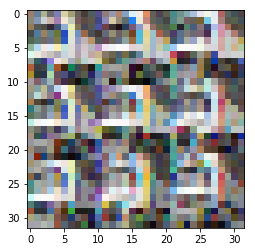

In [66]:
imshow(image[1])

In [67]:
def read_pickle_from_file(filename):
  with tf.gfile.Open(filename, 'rb') as f:
    data_dict = pickle.load(f, encoding='latin1')
  return data_dict

data_dict = read_pickle_from_file('../cifar10-data/cifar-10-batches-py/test_batch')

In [83]:
data=data_dict['data']
labels = data_dict['labels']
               

In [84]:
labels[0]

3

In [74]:
IMAGE_SHAPE = [3, 32,32]

In [92]:
image = data[2]

In [93]:
img = np.reshape(image, IMAGE_SHAPE)

In [94]:
img.shape

(3, 32, 32)

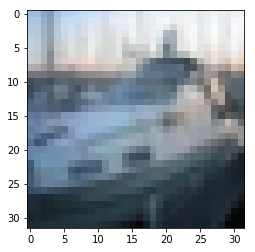

In [95]:
imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')